### Global analysis (no marginalization)
This notebook analyses and plots the global results of mode1 and mode4 with no marginalization on graph properties.


The results are based on

-----------
OBS: Uncomment lines when mode4 is ready to be analysed. Feel free to add what you want

In [1]:
import pandas as pd
import joypy
from evaluation_utils import read_processed_shards, unpivot_bvaseline_model, unpivot_ssl_model
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
from scipy.stats import f_oneway
from tqdm import tqdm
import pylab as pl
import matplotlib as mpl
from collections import OrderedDict
import itertools
from constants import MODE_1_PROCESSED_DIR, ALL_MODELS, TRAINING_SCHEMES, BASELINES, ENCODERS, TEST_METRIC, GENERATION_ALL, AUXILIARY_ALL, HYBRID_ALL, CONTRAST_ALL, model_abbreviations
%matplotlib inline

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


##### INDEXING
General scheme of a column: `Encoder_model_scheme`
Example of a column: `GCN_AttributeMask_JL`

##### READING DATA
We read the data and remove graphs where any model has failed / crashed

In [58]:
# --------- READING DATA ---------
df1 = read_processed_shards(MODE_1_PROCESSED_DIR) # mode1
df1.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
df1.dropna(axis=0, inplace=True)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
concatenating


##### Global distribution results

Below we plot the distribution of test results for each of the baseline and SSL methods and training schemes.



In [59]:
df = unpivot_ssl_model(df1, TEST_METRIC, ssl_models=ALL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES)
df_baseline = unpivot_bvaseline_model(df1, TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES)

For the baselines, GIN seems to perform best. GCN and GAT performs similar.

<AxesSubplot: xlabel='test_rocauc_ovr', ylabel='Density'>

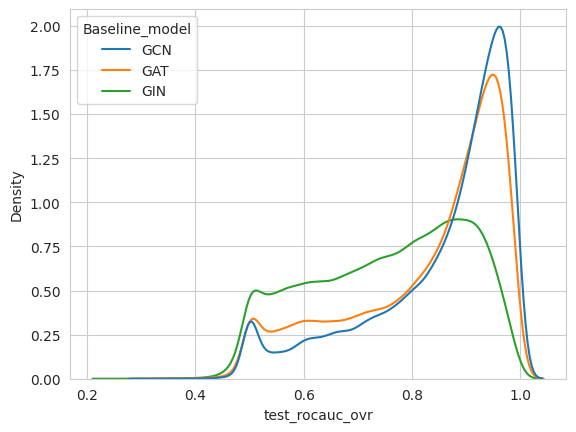

In [60]:
sns.kdeplot(data=df_baseline, x=TEST_METRIC, hue='Baseline_model')

Overall:
No big difference between GAT and GCN
Be careful with interpretation of the joint learning schemes. It can be in some cases the loss for one method is
just way higher than the other which impacts the learning. However, in two-stage training, the models have
time to change their parameters if the pretext task has found a bad set of parameters.

Investigate JL vs the two-stage trainings. It might show that when JL = 0.5, then two-stage is larger
because the pretext task might just have been bad.

GIN overall worse. Experiments in URL getting roc = 0.5 have many GIN in some cases.

MVMI_FT:

Overall good. Especially pretraining, finetuning.


MEtAl:
Joint learning has a lot of ROC=0.5. URL and PF actually seems to perform better.

G_zoom:
Very stable across the three learning schemes. JL seems to have a bit more ROC=0.5.

SUBGCON:
Also very stable across the three learning schemes. Does not seem to be influenced much here.

GraphInfoClust:
Joint learning is mostly impacted.

DeepGraphInfomax:
Also impacted by JL. PF seems to perform best

MERIT:
Does not seem to be impacted much by the learning scheme - very stable.

SelfGNNSplit:
JL and URL mostly impacted.

SelfGNNPPR:
Not impacted very much by learning scheme. Joint learning however seems to have more roc=0.5, followed by PF.

GCA:
JL Worse. much of the same as above

GBT:
Neither that much impacted by training scheme.

BGRL:
...

GraphPartitioning:
...

PairwiseAttrSim:
...

S2GRL:
...


NodeClusteringWithAlignment:
JL really good. However it is also the one with most roc=0.5 Either really good (roc=0.5) or really bad (roc=1)


GAE:
JL most roc=0.5

EdgeMask
...

CorrupedFeatureReconstruction:
Hard time on JL


CorruptedEmbeddingReconstruction:
Even harder time on JL than CorruptedFeatureReconstruction

AttributeMask:
Difficult on JL.

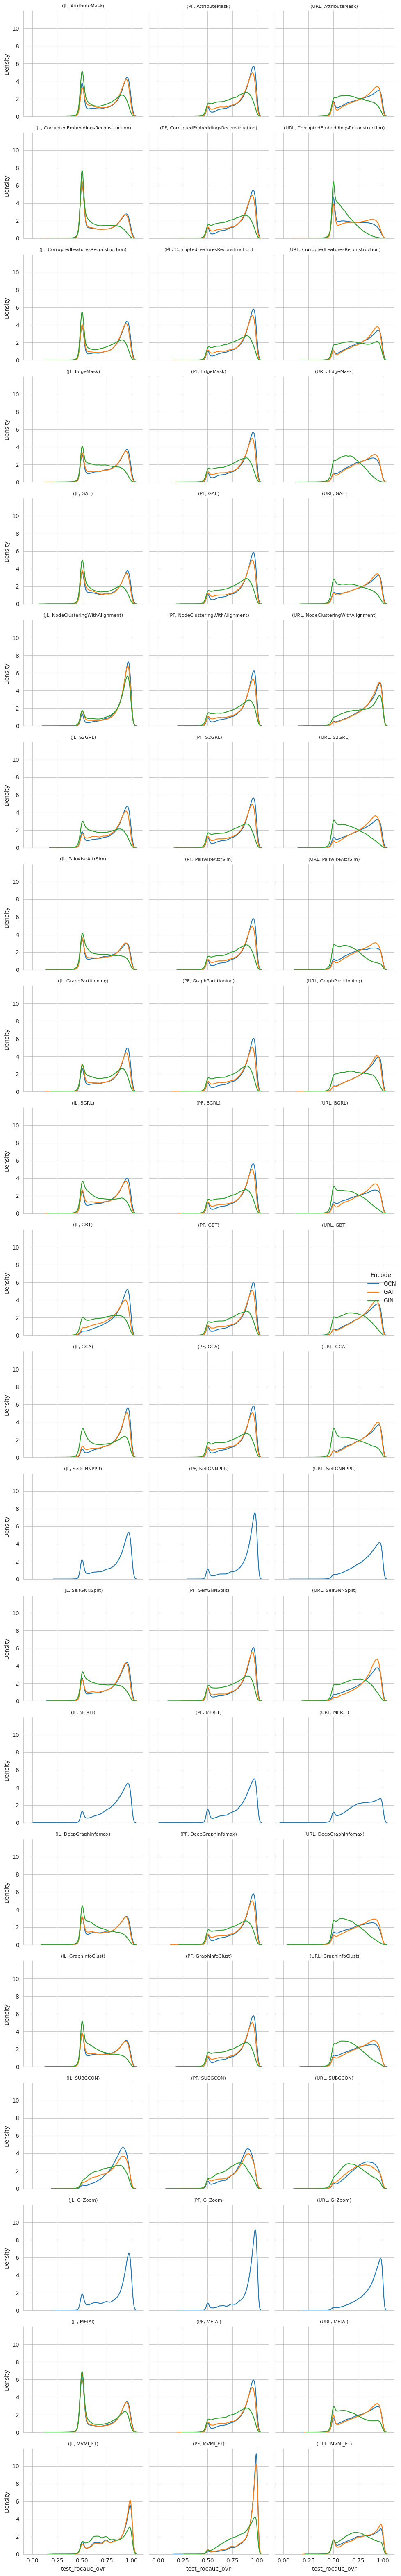

In [61]:
g = sns.FacetGrid(data=df, row='SSL_model', col='Training_scheme', hue='Encoder')
g.map(sns.kdeplot, TEST_METRIC)
g.set_titles(template="({col_name}, {row_name})", size=8)
g.add_legend()
plt.tight_layout()

##### Training scheme results

Below we plot the distribution of results for the three training schemes.

- Models trained with joint learning has a lot of samples which gets an ROC of 1/2 indicating they do not learn anything.
- For 2-stage training setups, most models get a high ROC while few get a low ROC.


In [62]:
grp = df.groupby('Training_scheme')
N_bins = 30
results = []
for key, v in grp:
    bins = pd.cut(v[TEST_METRIC], bins=np.linspace(0, 1, N_bins + 1)).value_counts().reset_index().rename(columns={ 'index': 'ROC-AUC', 'test_rocauc_ovr': 'Fraction' })
    bins['Fraction'] = bins['Fraction'] / bins['Fraction'].sum()
    bins['Training_scheme'] = key
    bins['ROC-AUC'] = bins['ROC-AUC'].apply(lambda x: f'({x.left:.2f}, {x.right:.2f}]')
    results += [bins]
bin_df = pd.concat(results)

/home/daen/.conda/envs/scara/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


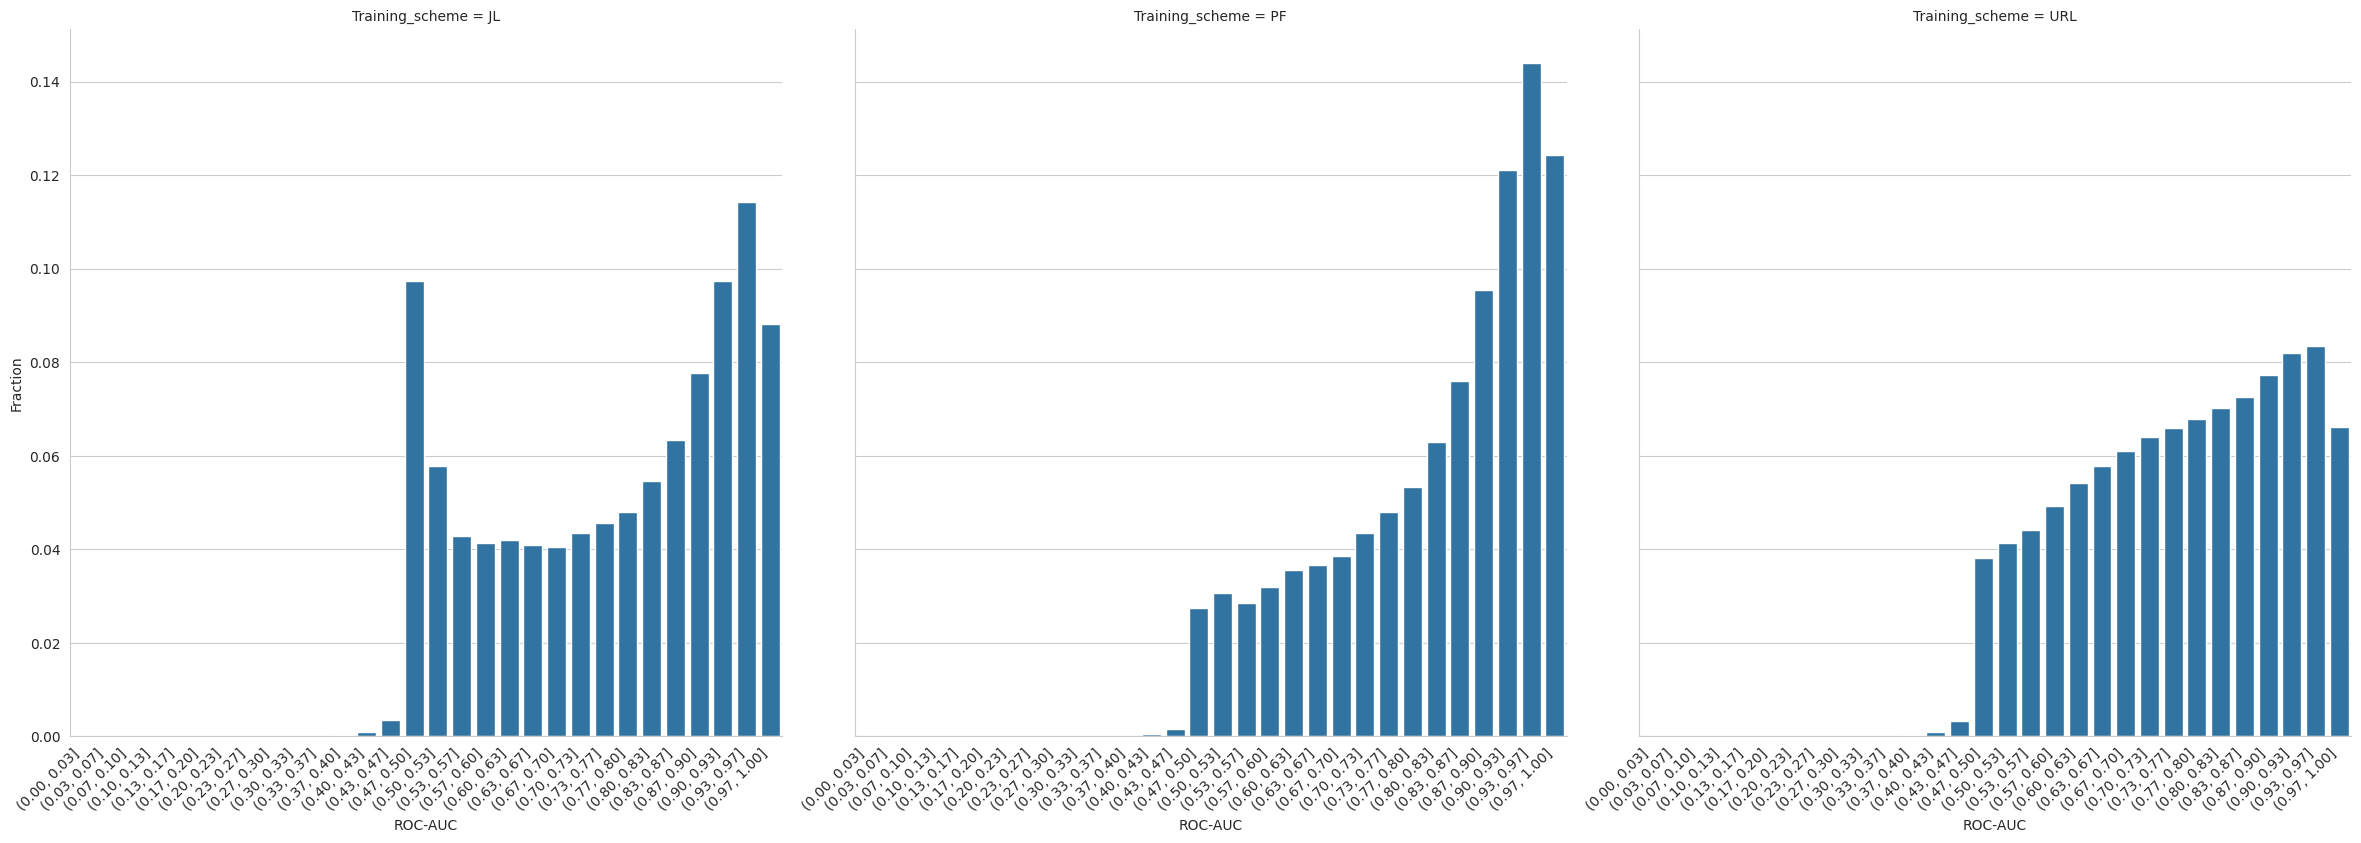

In [63]:
g = sns.FacetGrid(data=bin_df, col='Training_scheme', height=8, aspect=1)
g.map(sns.barplot, 'ROC-AUC', 'Fraction')
plt.tight_layout()
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

##### Pretext weight

One could easily think the high pretext weight is what causes the joint learning to perform bad. We therefore group all results by the pretext weight and bin the ROC score. We visualize the results as a line plot to see how the ROC score varies given the different bins.

Here we see the lower the pretext weight the higher the ROC score and vice versa.

In [64]:
JL = df[~df.pretext_weight.isna()]
N_bins = 30
results =[]
bin_edges = np.around(np.linspace(0, 1, N_bins + 1),2)
for key, v in JL.groupby('pretext_weight'):
    bins = pd.cut(v[TEST_METRIC], bins=bin_edges).value_counts().reset_index().rename(columns={ 'index': 'ROC-AUC', 'test_rocauc_ovr': 'Fraction' })
    bins['Fraction'] = bins['Fraction'] / bins['Fraction'].sum()
    bins['pretext_weight'] = key
    results += [bins]
bin_df = pd.concat(results)

/tmp/ipykernel_15264/768499500.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


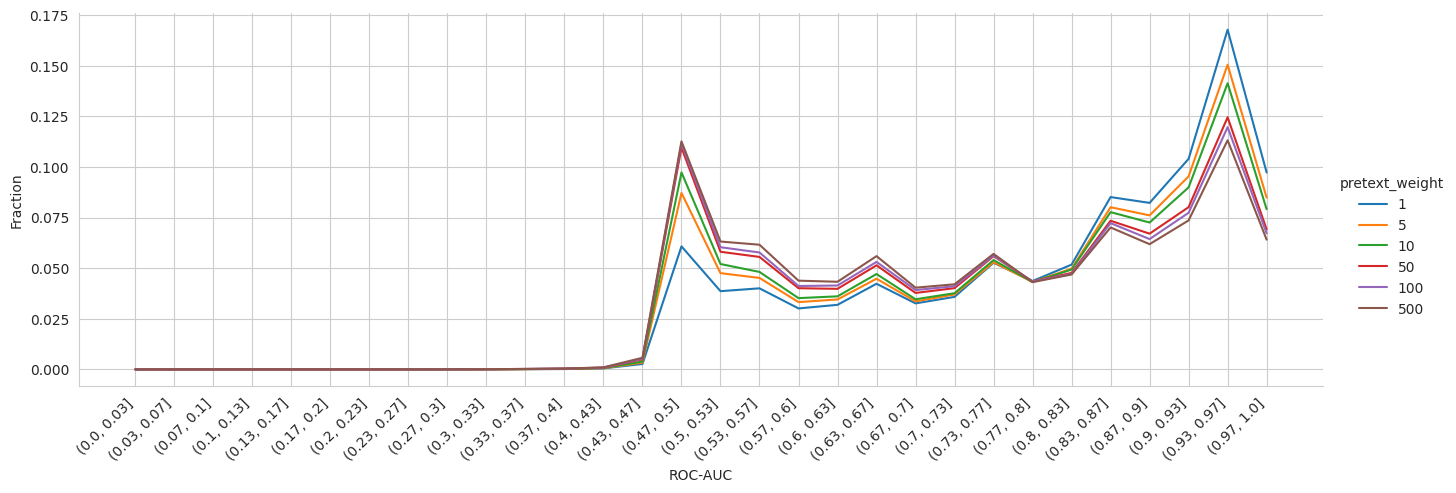

In [65]:
bins_copied = bin_df.copy()
bins_copied['ROC-AUC'] = bins_copied['ROC-AUC'].apply(lambda x: f'({x.left}, {x.right}]')
g = sns.FacetGrid(data=bins_copied, hue='pretext_weight', height=4.5, aspect=3)
g.map(sns.lineplot, 'ROC-AUC', 'Fraction')
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
g.add_legend()

In [66]:
# Define the high and low scores
interval_high = pd.Interval(left=0.93, right=0.97)
interval_low = pd.Interval(left=0.47, right=0.5)
high_scores = bin_df[bin_df['ROC-AUC'] == interval_high]
low_scores = bin_df[bin_df['ROC-AUC'] == interval_low]

# Assign the bin to each experiment
df_JL = df[df.Training_scheme == 'JL']
df_JL['SSL_model'] = df_JL['SSL_model'].apply(lambda model: model_abbreviations[model])
df_JL['ROC-AUC-bin'] = pd.cut(df_JL[TEST_METRIC], bins=bin_edges)

# Select high and low scores across all experiments
df_JL_high_scores = df_JL[df_JL['ROC-AUC-bin'].isin(high_scores['ROC-AUC'])]
df_JL_low_scores = df_JL[df_JL['ROC-AUC-bin'].isin(low_scores['ROC-AUC'])]

# Compute the counts for each model
df_JL_high_scores_count = df_JL_high_scores.groupby('SSL_model').count().rename(columns={ TEST_METRIC: 'total_count'})[['total_count']]
df_JL_low_scores_count = df_JL_low_scores.groupby('SSL_model').count().rename(columns={ TEST_METRIC: 'total_count'})[['total_count']]

# Compute the counts for each (model, pretext weight)
df_JL_high_scores_grouped = df_JL_high_scores.groupby(['SSL_model', 'pretext_weight']).count().rename(columns={ TEST_METRIC: 'count'})[['count']]
df_JL_low_scores_grouped = df_JL_low_scores.groupby(['SSL_model', 'pretext_weight']).count().rename(columns={ TEST_METRIC: 'count'})[['count']]

# Merge the counts for each model with counts for each (model, pretext weight)
df_JL_high_scores_grouped = df_JL_high_scores_grouped.join(other=df_JL_high_scores_count, on='SSL_model')
df_JL_low_scores_grouped = df_JL_low_scores_grouped.join(other=df_JL_low_scores_count, on='SSL_model')

# # Compute the fraction
df_JL_high_scores_grouped['count_fraction'] = df_JL_high_scores_grouped['count'] / df_JL_high_scores_grouped['total_count']
df_JL_low_scores_grouped['count_fraction'] = df_JL_low_scores_grouped['count'] / df_JL_low_scores_grouped['total_count']

/tmp/ipykernel_15264/3390778969.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_JL['SSL_model'] = df_JL['SSL_model'].apply(lambda model: model_abbreviations[model])
/tmp/ipykernel_15264/3390778969.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_JL['ROC-AUC-bin'] = pd.cut(df_JL[TEST_METRIC], bins=bin_edges)


We now also condition on the SSL model. Here, we choose the ROC-AUC bin which has the highest frequency. In this case it is (0.93, 0.97]. We then see for the given bin, how much does the frequency vary between the pretext weight. This can indicate how many experiments with a specific pretext weight resulted in this ROC-AUC score which in this case is a good and high ROC-AUC score.

##### Most variance
- CorruptedEmbeddingReconstruction
- GraphInfoClust
- DeepGraphInfomax
- EdgeMask
- GraphInfoClust
- MVMI_FT
- PairwiseAttrSim
- SelfGNNSplit

##### Least variance
- AttributeMask
- CorruptedFeatureReconstruction
- GBT
- GCA
- G_Zoom
- MEtAl
- NodeClusteringWithAlignment

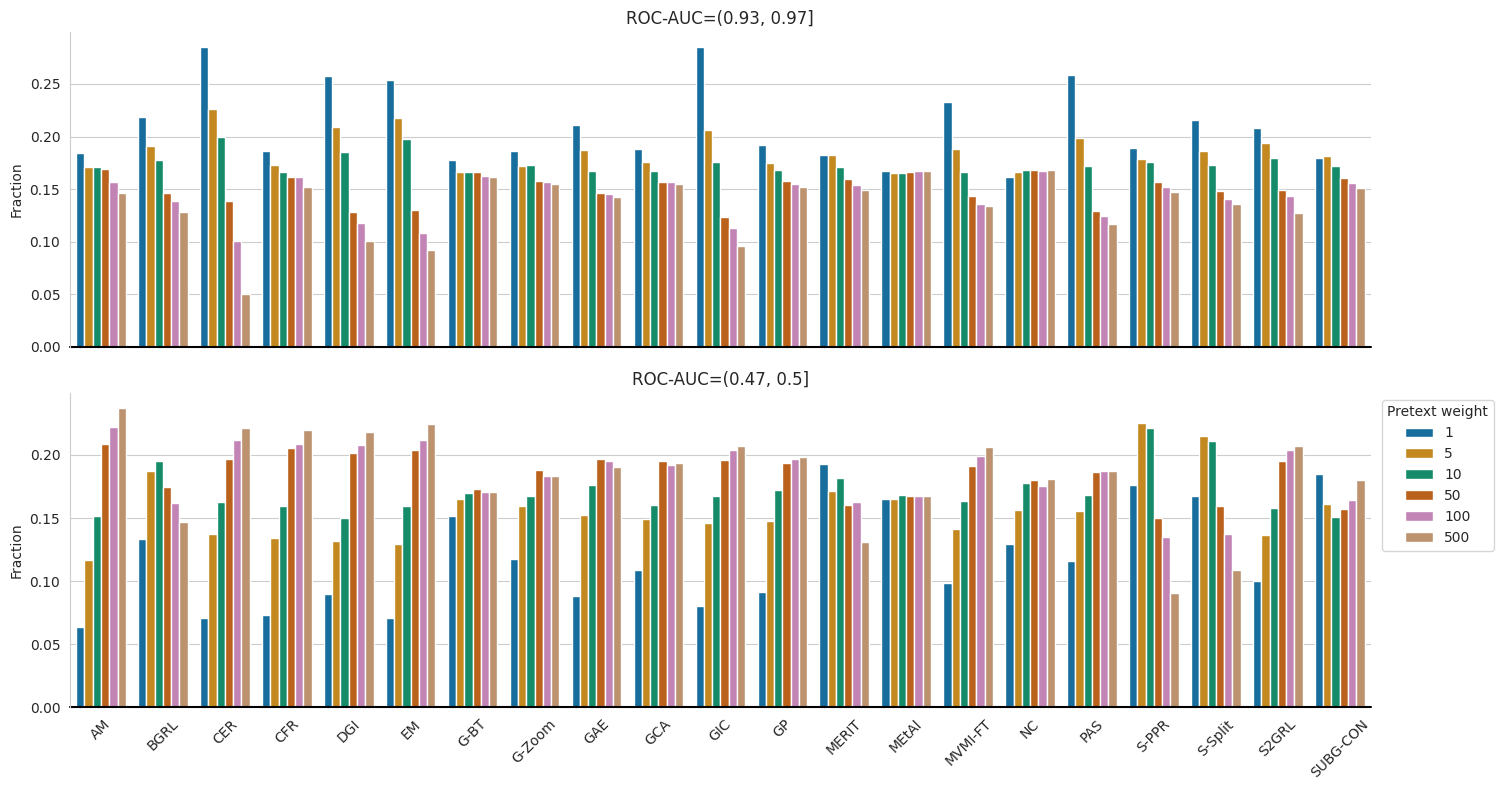

In [67]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)
y_label = 'Fraction'

# ax1.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6, color='black')
# ax2.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6, color='black')
sns.set_style("whitegrid")


sns.barplot(data=df_JL_high_scores_grouped.reset_index(), x='SSL_model', y='count_fraction', hue='pretext_weight', ax=ax1,
            palette=sns.color_palette('colorblind')).set(ylabel=y_label, title=f'ROC-AUC={interval_high}')
sns.barplot(data=df_JL_low_scores_grouped.reset_index(), x='SSL_model', y='count_fraction', hue='pretext_weight', ax=ax2,
            palette=sns.color_palette('colorblind')).set(ylabel=y_label, title=f'ROC-AUC={interval_low}')


ax2.tick_params(axis='x', labelrotation=45)
ax1.get_legend().remove()
ax2.legend(loc='upper right', bbox_to_anchor=(1.1, 1), title='Pretext weight')
ax1.set_xlabel('')
ax2.set_xlabel('')


sns.despine(bottom=True)
ax1.axhline(0, color="k", clip_on=False)
ax2.axhline(0, color="k", clip_on=False)

plt.tight_layout()

We also plot the total amount of experiments in each of the bins given the pretext weight. Here CorruptedEmbbedingReconstruction is the method with the fewest experiments (~1k) for a pretext weight of 500. Also, the higher the pretext weight the less evidence.

In [68]:
best_models = pd.pivot_table(
    df,
    index='SSL_model',
    columns=['Training_scheme', 'Encoder'],
    values='test_rocauc_ovr',
    aggfunc=lambda x: f'{x.mean():.2f}±{x.std():.2f}'
)

##### Mean and std global results for all models
Here we report the mean and std test metric of all models per main category:
- Generation-based
- Auxiliary-based
- Contrast-based
- Hybrid


In [91]:
def to_latex_table(df):
    for model, r in df.iterrows():
        lines = ['\\texttt{' + model + '}']
        lists = []
        for train in ['PF', 'URL', 'JL']:
            for enc in ['GCN', 'GAT', 'GIN']:
                line = r[(train, enc)]
                if pd.isna(line):
                    lines += ['-']
                    continue
                line = line.replace('±', '\pm')
                lines += [f' ${line}$']
                lists += [enc + '-' + train]
        print(' &'.join(lines))
        print('\\\\')


In [92]:
generation_df = best_models.loc[GENERATION_ALL]
generation_df

Training_scheme                           JL                               PF  \
Encoder                                  GAT        GCN        GIN        GAT   
SSL_model                                                                       
AttributeMask                      0.77±0.17  0.78±0.18  0.71±0.17  0.82±0.14   
CorruptedEmbeddingsReconstruction  0.70±0.18  0.71±0.18  0.64±0.15  0.82±0.14   
CorruptedFeaturesReconstruction    0.77±0.18  0.79±0.18  0.70±0.17  0.83±0.14   
EdgeMask                           0.76±0.17  0.78±0.17  0.69±0.15  0.82±0.14   
GAE                                0.74±0.18  0.76±0.18  0.69±0.16  0.82±0.15   

Training_scheme                                                URL             \
Encoder                                  GCN        GIN        GAT        GCN   
SSL_model                                                                       
AttributeMask                      0.85±0.14  0.76±0.14  0.79±0.14  0.78±0.15   
CorruptedEmbeddingsReconstruction  0.84±0.14  0.75±0.14  0.72±0.15  0.69±0.15   
CorruptedFeaturesReconstruction    0.85±0.14  0.76±0.14  0.81±0.14  0.80±0.14   
EdgeMask                           0.85±0.14  0.75±0.14  0.79±0.13  0.77±0.14   
GAE                                0.85±0.14  0.76±0.14  0.79±0.14  0.79±0.15   

Training_scheme                               
Encoder                                  GIN  
SSL_model                                     
AttributeMask                      0.71±0.14  
CorruptedEmbeddingsReconstruction  0.61±0.10  
CorruptedFeaturesReconstruction    0.74±0.15  
EdgeMask                           0.67±0.12  
GAE                                0.70±0.14

In [93]:
to_latex_table(generation_df)

\texttt{AttributeMask} & $0.85\pm0.14$ & $0.82\pm0.14$ & $0.76\pm0.14$ & $0.78\pm0.15$ & $0.79\pm0.14$ & $0.71\pm0.14$ & $0.78\pm0.18$ & $0.77\pm0.17$ & $0.71\pm0.17$
\\
\texttt{CorruptedEmbeddingsReconstruction} & $0.84\pm0.14$ & $0.82\pm0.14$ & $0.75\pm0.14$ & $0.69\pm0.15$ & $0.72\pm0.15$ & $0.61\pm0.10$ & $0.71\pm0.18$ & $0.70\pm0.18$ & $0.64\pm0.15$
\\
\texttt{CorruptedFeaturesReconstruction} & $0.85\pm0.14$ & $0.83\pm0.14$ & $0.76\pm0.14$ & $0.80\pm0.14$ & $0.81\pm0.14$ & $0.74\pm0.15$ & $0.79\pm0.18$ & $0.77\pm0.18$ & $0.70\pm0.17$
\\
\texttt{EdgeMask} & $0.85\pm0.14$ & $0.82\pm0.14$ & $0.75\pm0.14$ & $0.77\pm0.14$ & $0.79\pm0.13$ & $0.67\pm0.12$ & $0.78\pm0.17$ & $0.76\pm0.17$ & $0.69\pm0.15$
\\
\texttt{GAE} & $0.85\pm0.14$ & $0.82\pm0.15$ & $0.76\pm0.14$ & $0.79\pm0.15$ & $0.79\pm0.14$ & $0.70\pm0.14$ & $0.76\pm0.18$ & $0.74\pm0.18$ & $0.69\pm0.16$
\\


In [72]:
auxiliary_df = best_models.loc[AUXILIARY_ALL]  
auxiliary_df

Training_scheme                     JL                               PF  \
Encoder                            GAT        GCN        GIN        GAT   
SSL_model                                                                 
NodeClusteringWithAlignment  0.85±0.15  0.87±0.14  0.83±0.16  0.83±0.14   
S2GRL                        0.80±0.15  0.82±0.15  0.71±0.15  0.82±0.14   
PairwiseAttrSim              0.75±0.17  0.75±0.17  0.69±0.15  0.82±0.14   
GraphPartitioning            0.78±0.17  0.81±0.17  0.73±0.16  0.82±0.14   

Training_scheme                                          URL             \
Encoder                            GCN        GIN        GAT        GCN   
SSL_model                                                                 
NodeClusteringWithAlignment  0.86±0.13  0.77±0.15  0.85±0.13  0.84±0.13   
S2GRL                        0.85±0.14  0.75±0.14  0.80±0.13  0.79±0.14   
PairwiseAttrSim              0.85±0.14  0.76±0.14  0.79±0.14  0.77±0.14   
GraphPartitioning            0.85±0.13  0.76±0.14  0.82±0.13  0.82±0.13   

Training_scheme                         
Encoder                            GIN  
SSL_model                               
NodeClusteringWithAlignment  0.79±0.15  
S2GRL                        0.67±0.13  
PairwiseAttrSim              0.68±0.13  
GraphPartitioning            0.71±0.14

In [73]:
to_latex_table(auxiliary_df)

\texttt{NodeClusteringWithAlignment} & $0.86\pm0.13$ & $0.83\pm0.14$ & $0.77\pm0.15$ & $0.84\pm0.13$ & $0.85\pm0.13$ & $0.79\pm0.15$ & $0.87\pm0.14$ & $0.85\pm0.15$ & $0.83\pm0.16$
\\
\texttt{S2GRL} & $0.85\pm0.14$ & $0.82\pm0.14$ & $0.75\pm0.14$ & $0.79\pm0.14$ & $0.80\pm0.13$ & $0.67\pm0.13$ & $0.82\pm0.15$ & $0.80\pm0.15$ & $0.71\pm0.15$
\\
\texttt{PairwiseAttrSim} & $0.85\pm0.14$ & $0.82\pm0.14$ & $0.76\pm0.14$ & $0.77\pm0.14$ & $0.79\pm0.14$ & $0.68\pm0.13$ & $0.75\pm0.17$ & $0.75\pm0.17$ & $0.69\pm0.15$
\\
\texttt{GraphPartitioning} & $0.85\pm0.13$ & $0.82\pm0.14$ & $0.76\pm0.14$ & $0.82\pm0.13$ & $0.82\pm0.13$ & $0.71\pm0.14$ & $0.81\pm0.17$ & $0.78\pm0.17$ & $0.73\pm0.16$
\\


In [18]:
contrast_df = best_models.loc[CONTRAST_ALL]
contrast_df

Training_scheme          JL                               PF             \
Encoder                 GAT        GCN        GIN        GAT        GCN   
SSL_model                                                                 
BGRL              0.77±0.16  0.79±0.16  0.69±0.15  0.82±0.15  0.85±0.14   
GBT               0.81±0.14  0.84±0.13  0.73±0.14  0.83±0.14  0.85±0.13   
GCA               0.82±0.15  0.84±0.14  0.72±0.16  0.83±0.14  0.85±0.14   
SelfGNNPPR              NaN  0.83±0.16        NaN        NaN  0.88±0.13   
SelfGNNSplit      0.79±0.16  0.80±0.16  0.69±0.15  0.83±0.14  0.85±0.14   
MERIT                   NaN  0.83±0.14        NaN        NaN  0.84±0.15   
DeepGraphInfomax  0.75±0.16  0.76±0.17  0.67±0.14  0.82±0.14  0.85±0.14   
GraphInfoClust    0.74±0.17  0.75±0.17  0.66±0.15  0.82±0.14  0.85±0.14   
SUBGCON           0.80±0.13  0.84±0.11  0.76±0.13  0.81±0.14  0.83±0.12   

Training_scheme                    URL                        
Encoder                 GIN        GAT        GCN        GIN  
SSL_model                                                     
BGRL              0.75±0.14  0.80±0.14  0.77±0.14  0.67±0.13  
GBT               0.76±0.14  0.81±0.13  0.81±0.13  0.70±0.13  
GCA               0.75±0.14  0.82±0.13  0.81±0.14  0.69±0.14  
SelfGNNPPR              NaN        NaN  0.83±0.13        NaN  
SelfGNNSplit      0.76±0.15  0.84±0.12  0.81±0.14  0.72±0.13  
MERIT                   NaN        NaN  0.79±0.15        NaN  
DeepGraphInfomax  0.75±0.14  0.78±0.14  0.76±0.14  0.67±0.12  
GraphInfoClust    0.75±0.14  0.78±0.14  0.76±0.14  0.67±0.12  
SUBGCON           0.75±0.13  0.77±0.13  0.79±0.12  0.71±0.13

In [89]:
contrast_df.loc[['DeepGraphInfomax']]

Training_scheme          JL                               PF             \
Encoder                 GAT        GCN        GIN        GAT        GCN   
SSL_model                                                                 
DeepGraphInfomax  0.75±0.16  0.76±0.17  0.67±0.14  0.82±0.14  0.85±0.14   

Training_scheme                    URL                        
Encoder                 GIN        GAT        GCN        GIN  
SSL_model                                                     
DeepGraphInfomax  0.75±0.14  0.78±0.14  0.76±0.14  0.67±0.12

In [86]:
to_latex_table(contrast_df.loc[['DeepGraphInfomax']])

PF GCN
PF GAT
PF GIN
URL GCN
URL GAT
URL GIN
JL GCN
JL GAT
JL GIN
\texttt{DeepGraphInfomax} & $0.85\pm0.14$ & $0.82\pm0.14$ & $0.75\pm0.14$ & $0.76\pm0.14$ & $0.78\pm0.14$ & $0.67\pm0.12$ & $0.76\pm0.17$ & $0.75\pm0.16$ & $0.67\pm0.14$
\\


In [20]:
hybrid_df = best_models.loc[HYBRID_ALL]
hybrid_df

Training_scheme         JL                               PF             \
Encoder                GAT        GCN        GIN        GAT        GCN   
SSL_model                                                                
G_Zoom                 NaN  0.84±0.16        NaN        NaN  0.89±0.13   
MEtAl            0.72±0.19  0.73±0.19  0.69±0.18  0.83±0.14  0.85±0.14   
MVMI_FT          0.83±0.15  0.82±0.16  0.77±0.16  0.90±0.12  0.91±0.11   

Training_scheme                   URL                        
Encoder                GIN        GAT        GCN        GIN  
SSL_model                                                    
G_Zoom                 NaN        NaN  0.87±0.12        NaN  
MEtAl            0.76±0.14  0.79±0.15  0.78±0.15  0.70±0.14  
MVMI_FT          0.83±0.13  0.80±0.15  0.78±0.15  0.74±0.14

In [21]:
to_latex_table(hybrid_df)

\texttt{G_Zoom} & $0.89\pm0.13$ &- &- & $0.87\pm0.12$ &- &- & $0.84\pm0.16$ &- &-
\\
\texttt{MEtAl} & $0.85\pm0.14$ & $0.83\pm0.14$ & $0.76\pm0.14$ & $0.78\pm0.15$ & $0.79\pm0.15$ & $0.70\pm0.14$ & $0.73\pm0.19$ & $0.72\pm0.19$ & $0.69\pm0.18$
\\
\texttt{MVMI_FT} & $0.91\pm0.11$ & $0.90\pm0.12$ & $0.83\pm0.13$ & $0.78\pm0.15$ & $0.80\pm0.15$ & $0.74\pm0.14$ & $0.82\pm0.16$ & $0.83\pm0.15$ & $0.77\pm0.16$
\\


In [22]:
best_models_baseline = pd.pivot_table(
    data=df_baseline,
    values=TEST_METRIC,
    columns='Baseline_model',
    aggfunc=lambda x: f'{x.mean():.2f}±{x.std():.2f}'
)
best_models_baseline

Baseline_model,GAT,GCN,GIN
test_rocauc_ovr,0.83±0.14,0.85±0.13,0.76±0.14


In [23]:
df.head()

,test_rocauc_ovr,pretext_weight,SSL_model,Encoder,Training_scheme,Graph_ID
0,0.808655,500,AttributeMask,GCN,JL,0
1,0.905296,500,AttributeMask,GCN,JL,1
2,0.868194,5,AttributeMask,GCN,JL,4
3,0.813202,50,AttributeMask,GCN,JL,5
4,0.934141,1,AttributeMask,GCN,JL,6


In [24]:
df_GCN = df[df.Encoder == 'GCN'][[TEST_METRIC, 'SSL_model', 'Training_scheme', 'Graph_ID']]

In [25]:
df_GCN

,test_rocauc_ovr,SSL_model,Training_scheme,Graph_ID
0,0.808655,AttributeMask,JL,0
1,0.905296,AttributeMask,JL,1
2,0.868194,AttributeMask,JL,4
3,0.813202,AttributeMask,JL,5
4,0.934141,AttributeMask,JL,6
...,...,...,...,...
16160590,0.929101,MVMI_FT,URL,99995
16160591,0.672357,MVMI_FT,URL,99996
16160592,0.500000,MVMI_FT,URL,99997
16160593,0.824405,MVMI_FT,URL,99998


In [26]:
df_pivoted = df_GCN.pivot(index=['Graph_ID', 'SSL_model'], columns='Training_scheme', values='test_rocauc_ovr')
df_pivoted.reset_index()

Training_scheme,Graph_ID,SSL_model,JL,PF,URL
0,0,AttributeMask,0.808655,0.949540,0.901102
1,0,BGRL,0.949540,0.942077,0.964500
2,0,CorruptedEmbeddingsReconstruction,0.810608,0.986923,0.510043
3,0,CorruptedFeaturesReconstruction,0.500000,0.953271,0.962617
4,0,DeepGraphInfomax,0.985981,0.966418,0.893500
...,...,...,...,...,...
2056798,99999,PairwiseAttrSim,0.853004,0.801509,0.760762
2056799,99999,S2GRL,0.871868,0.886584,0.500000
2056800,99999,SUBGCON,0.822253,0.871018,0.780833
2056801,99999,SelfGNNPPR,0.903244,0.922788,0.859944


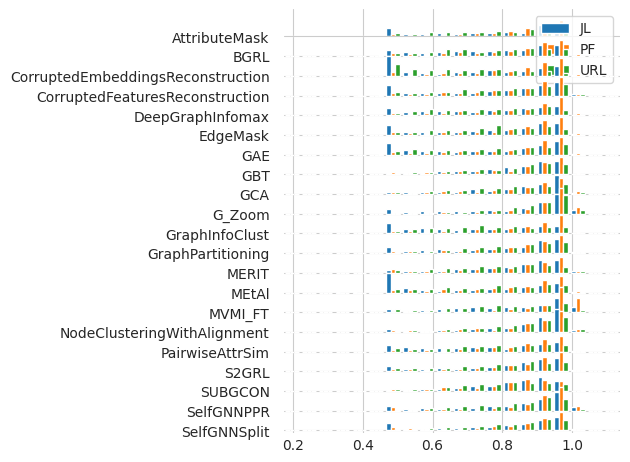

In [27]:
fig, axes = joypy.joyplot(df_pivoted.reset_index().drop(columns=['Graph_ID']).sample(n=10_000), 
                          by='SSL_model', fill=False, legend=True, hist=True, bins=20,
                          grid=True); pass

In [46]:
df

,test_rocauc_ovr,pretext_weight,SSL_model,Encoder,Training_scheme,Graph_ID
0,0.808655,500,AttributeMask,GCN,JL,0
1,0.905296,500,AttributeMask,GCN,JL,1
2,0.868194,5,AttributeMask,GCN,JL,4
3,0.813202,50,AttributeMask,GCN,JL,5
4,0.934141,1,AttributeMask,GCN,JL,6
...,...,...,...,...,...,...
16748248,1.000000,None,MVMI_FT,GIN,URL,99995
16748249,0.863135,None,MVMI_FT,GIN,URL,99996
16748250,0.908974,None,MVMI_FT,GIN,URL,99997
16748251,0.962585,None,MVMI_FT,GIN,URL,99998


In [51]:
df_mean_results = df.groupby(['SSL_model', 'Encoder', 'Training_scheme'])[TEST_METRIC].mean().reset_index()
df_mean_results[TEST_METRIC] = df_mean_results[TEST_METRIC].round(decimals=2)
df_mean_results['rank'] = df_mean_results.groupby(['Encoder', 'Training_scheme'])[TEST_METRIC].rank(ascending=False, method='min')
df_mean_results = df_mean_results.astype({ 'rank': int})
df_mean_results

,SSL_model,Encoder,Training_scheme,test_rocauc_ovr,rank
0,AttributeMask,GAT,JL,0.77,9
1,AttributeMask,GAT,PF,0.82,8
2,AttributeMask,GAT,URL,0.79,10
3,AttributeMask,GCN,JL,0.78,14
4,AttributeMask,GCN,PF,0.85,5
...,...,...,...,...,...
166,SelfGNNSplit,GCN,PF,0.85,5
167,SelfGNNSplit,GCN,URL,0.81,5
168,SelfGNNSplit,GIN,JL,0.69,10
169,SelfGNNSplit,GIN,PF,0.76,3


In [31]:
x.rank(method='min')

,a,b
2,4.0,1.0
0,1.0,1.0
4,1.0,5.0
3,5.0,4.0
1,3.0,1.0


In [95]:
df_mean_results

,SSL_model,Encoder,Training_scheme,test_rocauc_ovr,rank
0,AttributeMask,GAT,JL,0.77,9
1,AttributeMask,GAT,PF,0.82,8
2,AttributeMask,GAT,URL,0.79,10
3,AttributeMask,GCN,JL,0.78,14
4,AttributeMask,GCN,PF,0.85,5
...,...,...,...,...,...
166,SelfGNNSplit,GCN,PF,0.85,5
167,SelfGNNSplit,GCN,URL,0.81,5
168,SelfGNNSplit,GIN,JL,0.69,10
169,SelfGNNSplit,GIN,PF,0.76,3


/tmp/ipykernel_15264/3732404121.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), fontsize=30)


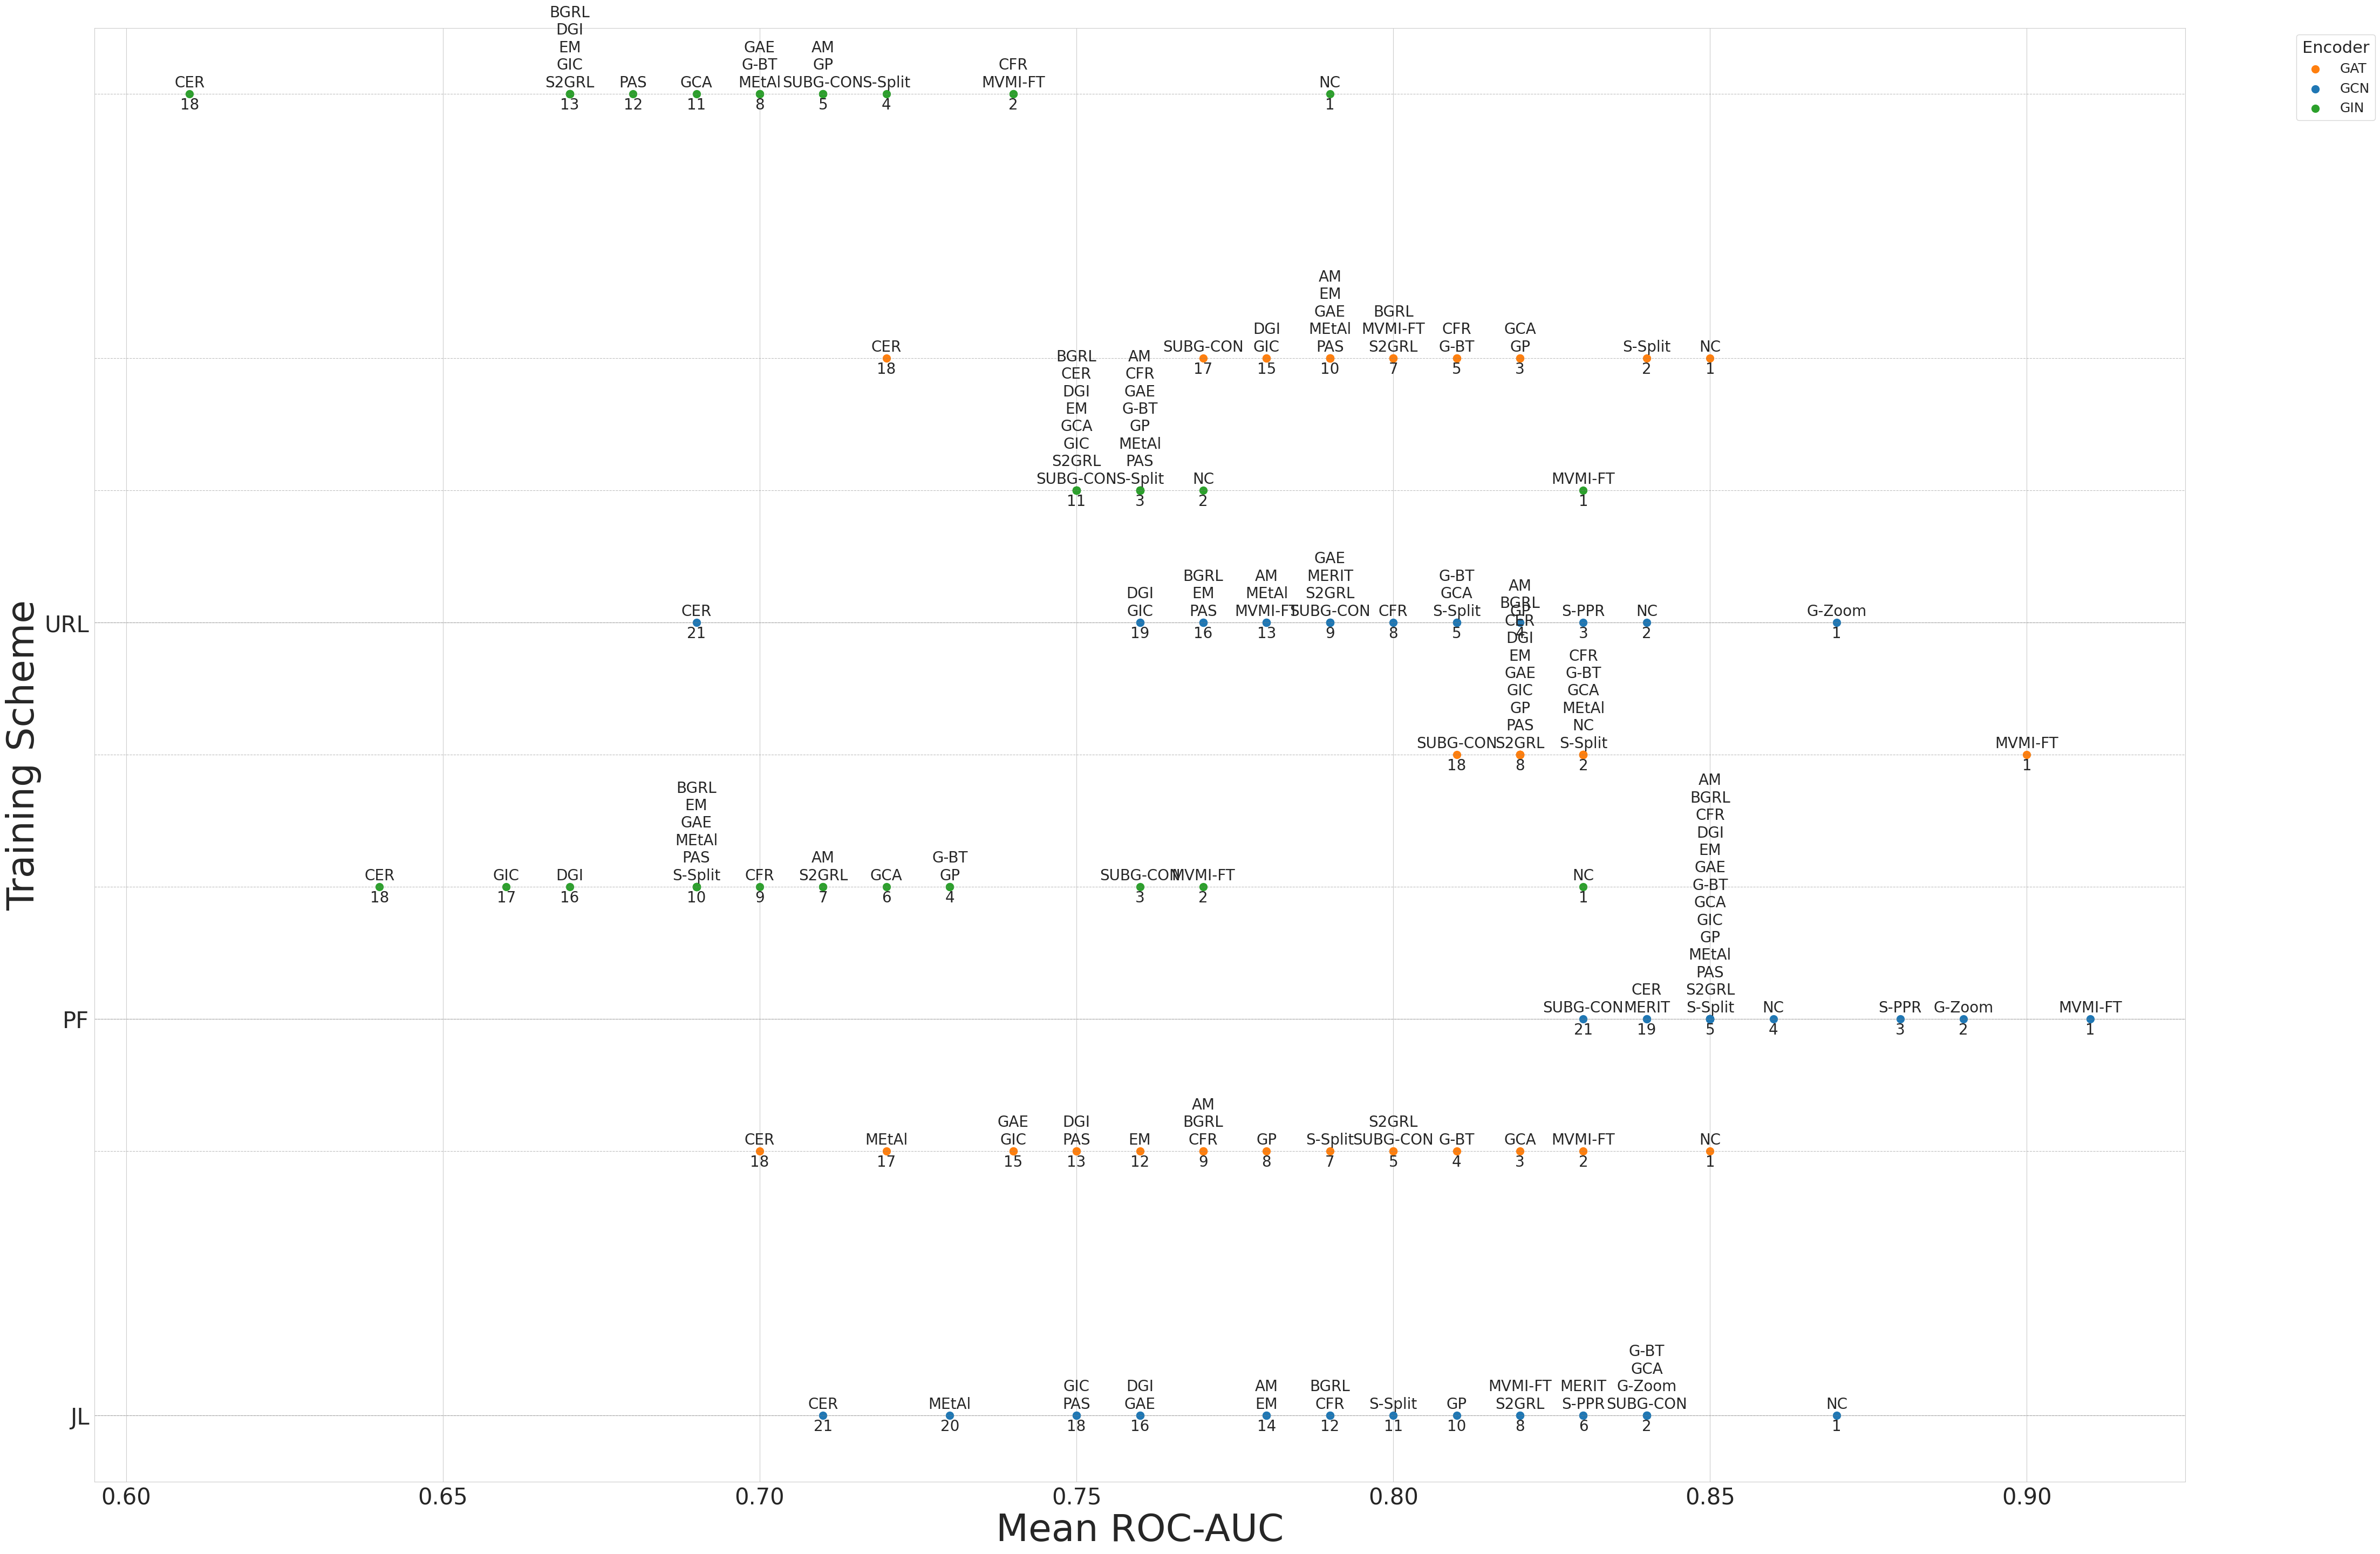

In [113]:
import matplotlib.pyplot as plt
import numpy as np

_, axs = plt.subplots(nrows=1, ncols=1, figsize=(50, 35))

# Define the dodge width and marker size
dodge_width = 2 / len(ENCODERS)
marker_size = 100

# Create a dictionary to store the scatter plot objects for the legend
scatters = {}
colors = {hue: plt.get_cmap('tab10')(i) for i, hue in enumerate(ENCODERS)}
encoder_offsets = { encoder: i for (i, encoder) in enumerate(ENCODERS)}
training_scheme_offsets = { scheme: i for (i, scheme) in enumerate(TRAINING_SCHEMES)}


# for metric, sub_grp in df_.groupby([TEST_METRIC, 'Encoder']):
# Iterate through the y-axis categories (Training_scheme) and hue categories (Encoder)

for (scheme, encoder), sub_grp in df_mean_results.groupby(['Training_scheme', 'Encoder']):
    x_values = sub_grp[TEST_METRIC].values
    y_value = training_scheme_offsets[scheme]
    y_values = np.full(len(x_values), y_value)


    # Calculate the y-offset for the hue category

    y_offset = (encoder_offsets[encoder]) * dodge_width
    scatters[encoder] = axs.scatter(x_values, y_values + y_offset, s=marker_size, color=colors[encoder])
    axs.axhline(y_values[0] + y_offset, linestyle='--', color='gray', alpha=0.5, linewidth=0.8)

    for metric, sub_grp_metric in sub_grp.groupby(TEST_METRIC):
        ssl_abbreviations = [model_abbreviations[model] for model in sub_grp_metric.SSL_model.values]
        ssl_text = '\n'.join(ssl_abbreviations)

        axs.annotate(ssl_text, (metric, y_values[0] + y_offset), va='bottom', ha='center', fontsize=20, xytext=(0, 5), textcoords='offset points')

        ranks = sub_grp_metric['rank'].values
        if len(ranks) > 1:
            assert ranks.all()

        rank_label = ranks[0]
        axs.annotate(rank_label, (metric, y_values[0] + y_offset), va='top', ha='center', fontsize=20, xytext=(0, -5), textcoords='offset points')


# Set the y-axis labels
axs.set_yticks(range(len(TRAINING_SCHEMES)), TRAINING_SCHEMES, fontsize=30)
axs.set_xticklabels(axs.get_xticklabels(), fontsize=30)

# Add axis labels and show the plot
axs.set_xlabel('Mean ROC-AUC', fontsize=50)
axs.set_ylabel('Training Scheme', fontsize=50)

# Create a legend using the scatter plot objects
axs.legend(scatters.values(), scatters.keys(), title='Encoder',
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18, title_fontsize=22)

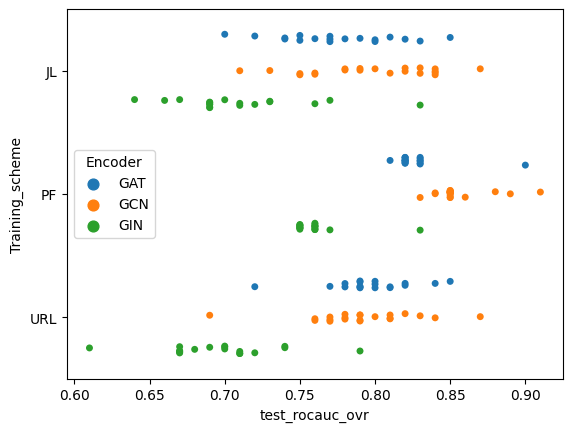

In [34]:
g = sns.stripplot(data=df_mean_results, y='Training_scheme', x=TEST_METRIC, hue='Encoder', dodge=True)

In [35]:
g

<AxesSubplot: xlabel='test_rocauc_ovr', ylabel='Training_scheme'>

NameError: name 'df_' is not defined

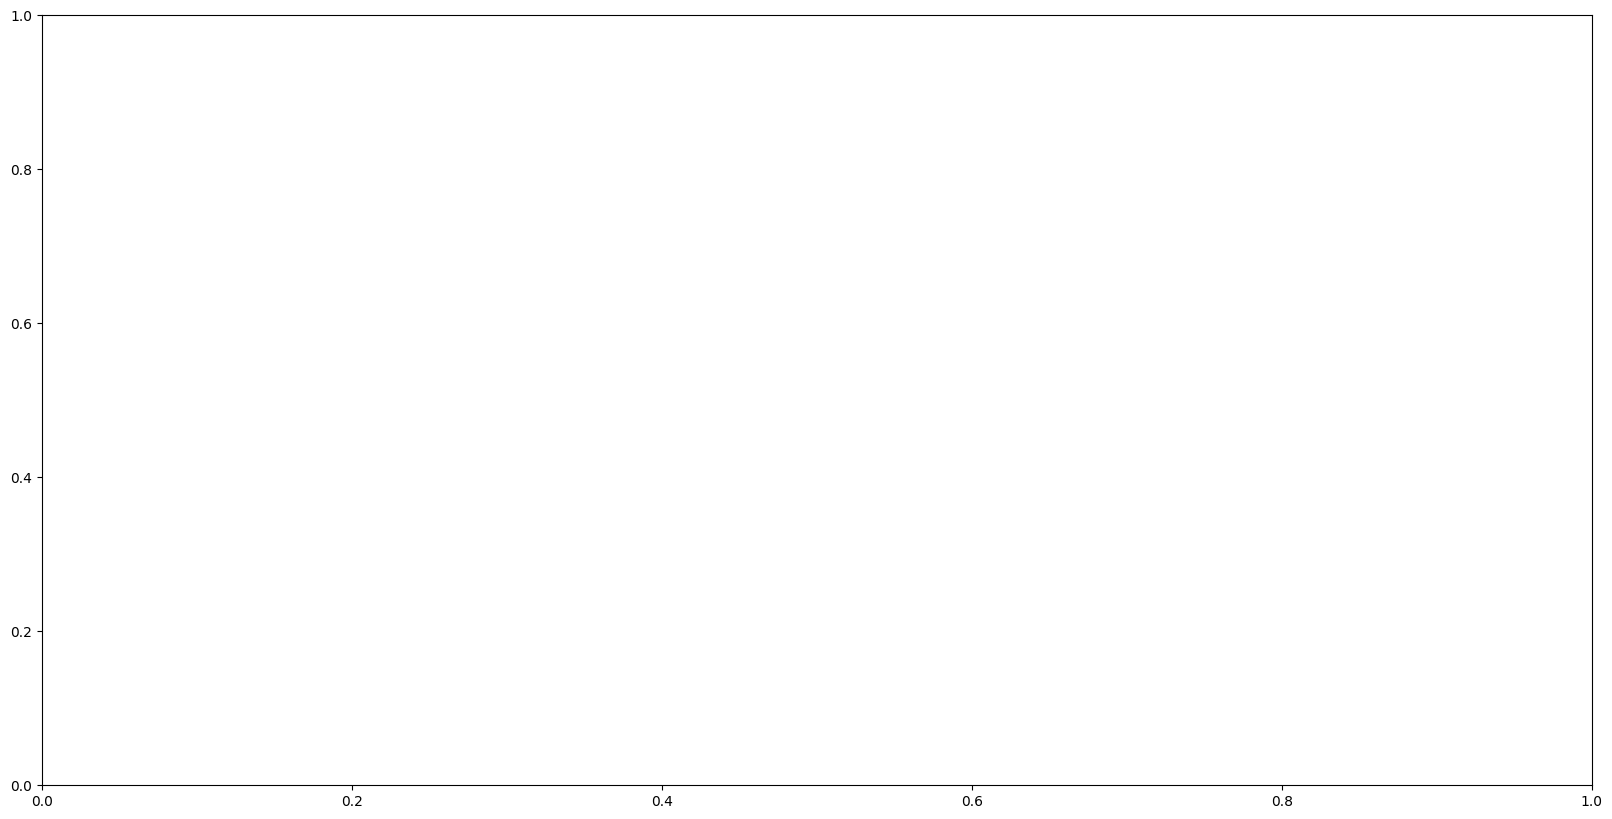

In [36]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
for encoder in ENCODERS:
    sns.scatterplot(data=df_, x=TEST_METRIC, y='Encoder', ax=axs)
    for metric, sub_grp in df_.groupby([TEST_METRIC, 'Encoder']):
        ssl_abbreviations = [model_abbreviations[model] for model in sub_grp.SSL_model.tolist()]
        ssl_text = '\n'.join(ssl_abbreviations)
        axs.annotate(ssl_text, (metric[0], metric[1]), va='bottom', fontsize=8, rotation=45)

        ranks = sub_grp['rank'].tolist()
        rank_label = f'[{min(ranks)}-{max(ranks)}]' if len(ranks) > 1 else ranks[0]

AxesSubplot(0.125,0.11;0.775x0.77)


[Text(0.5, 0, 'SSL Model'), Text(0, 0.5, 'ROC-AUC')]

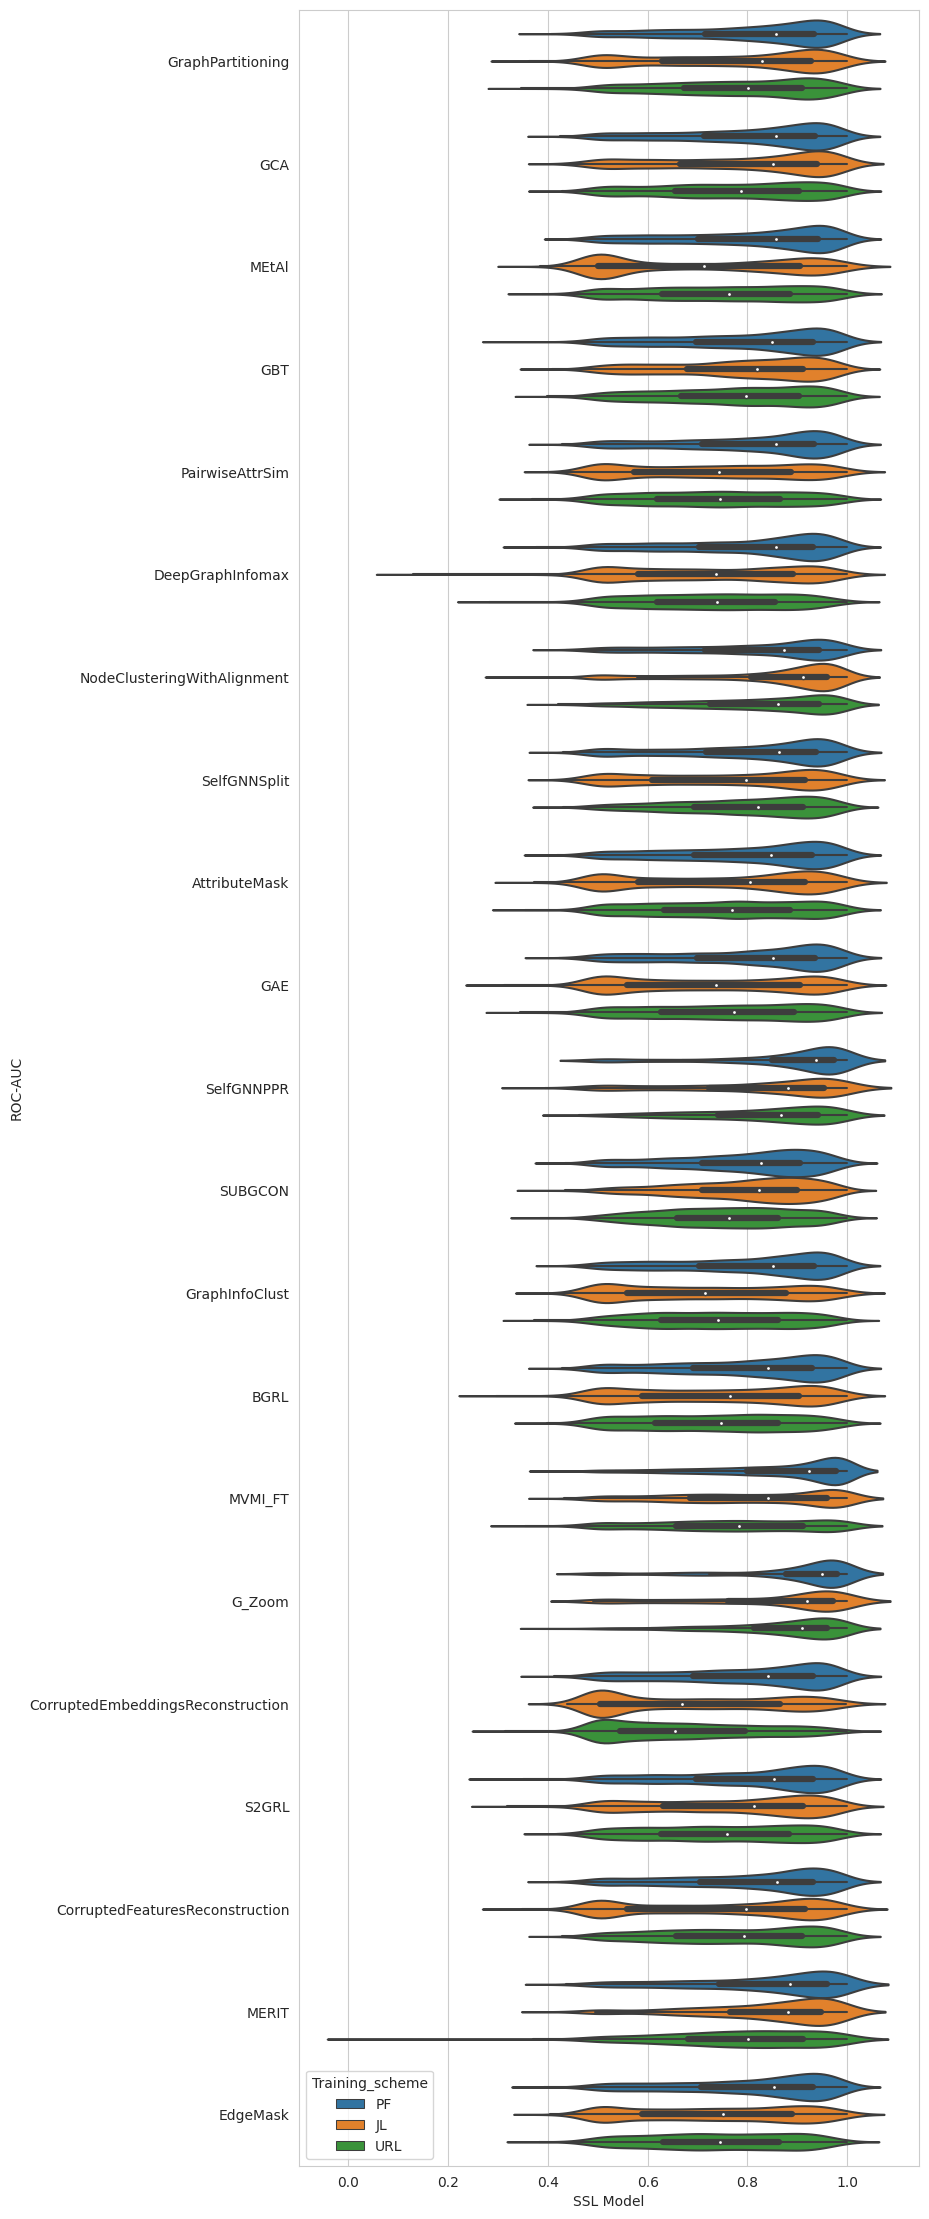

In [ ]:
sns.set_style("whitegrid")
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 28))
g = sns.violinplot(data=df.sample(n=100_000), x=TEST_METRIC, y='SSL_model', hue='Training_scheme', ax=axs)
print(g)
g.set(xlabel='SSL Model', ylabel='ROC-AUC')
# g.set_yticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right'); pass